In [3]:
import pandas as pd
from collections import Counter

# ==============================
# Load Data
# ==============================
truth_file = "gold.tsv"      # must contain: id, text, hate_type, hate_severity, to_whom
pred_file = "pred.tsv"       # must contain: id, hate_type, hate_severity, to_whom

truth_df = pd.read_csv(truth_file, sep="\t")
pred_df = pd.read_csv(pred_file, sep="\t")

# Merge gold + predictions
merged_df = pd.merge(truth_df, pred_df, on="id", suffixes=("_true", "_pred"))

# ==============================
# Error Analysis Function
# ==============================
def analyze_errors(df, col, top_n=10, example_n=3):
    true_col = f"{col}_true"
    pred_col = f"{col}_pred"
    valid_df = df.dropna(subset=[true_col, pred_col])
    misclassified = valid_df[valid_df[true_col] != valid_df[pred_col]]

    # Count confusion pairs
    error_patterns = Counter(
        [f"{row[true_col]}->{row[pred_col]}"
         for _, row in misclassified.iterrows()
         if pd.notna(row[true_col]) and pd.notna(row[pred_col])]
    )

    # Collect representative examples
    examples = {}
    for err, _ in error_patterns.most_common(top_n):
        true_label, pred_label = err.split("->")
        subset = misclassified[
            (misclassified[true_col] == true_label) &
            (misclassified[pred_col] == pred_label)
        ]
        examples[err] = subset[["id", "text", true_col, pred_col]].head(example_n)
    return misclassified, error_patterns.most_common(top_n), examples

# ==============================
# Run analysis for each label
# ==============================
results = {}
for col in ["hate_type", "hate_severity", "to_whom"]:
    misclassified, top_errors, examples = analyze_errors(merged_df, col)
    results[col] = {
        "total": len(merged_df),
        "errors": len(misclassified),
        "error_rate": len(misclassified) / len(merged_df) * 100,
        "top_errors": top_errors,
        "examples": examples
    }

# ==============================
# Generate one-line qualitative summaries
# ==============================
def generate_summary(col, results):
    """Create one-line qualitative error summaries from actual examples."""
    data = results[col]
    top_err, count = data["top_errors"][0]  # top confusion pair
    sample_df = data["examples"][top_err]
    if not sample_df.empty:
        example_text = sample_df.iloc[0]["text"]
        true_label = sample_df.iloc[0][f"{col}_true"]
        pred_label = sample_df.iloc[0][f"{col}_pred"]
        summary = (
            f"{col.replace('_', ' ').title()}: "
            f"Example '{example_text[:50]}...' was labeled '{true_label}' "
            f"but predicted '{pred_label}', showing contextual overlap."
        )
        return summary
    return f"{col.replace('_', ' ').title()}: No examples found."

# ==============================
# Print overall results + summaries
# ==============================
for col, stats in results.items():
    print(f"\n=== {col.upper()} ===")
    print(f"Error rate: {stats['error_rate']:.2f}% ({stats['errors']}/{stats['total']})")
    for err, count in stats["top_errors"]:
        print(f"{err}: {count}")
    print("\nTop qualitative summary:")
    print(generate_summary(col, results))
    print("-" * 90)



=== HATE_TYPE ===
Error rate: 8.31% (848/10200)
Abusive->Political Hate: 228
Political Hate->Abusive: 220
Abusive->Profane: 109
Profane->Abusive: 109
Political Hate->Profane: 44
Abusive->Religious Hate: 34
Profane->Political Hate: 33
Religious Hate->Abusive: 30
Sexism->Abusive: 12
Political Hate->Religious Hate: 10

Top qualitative summary:
Hate Type: Example 'বিদ্যুৎ জ্বালানি খাতে আওয়ামী লীগের আমলে সবচেয়ে বেশ...' was labeled 'Abusive' but predicted 'Political Hate', showing contextual overlap.
------------------------------------------------------------------------------------------

=== HATE_SEVERITY ===
Error rate: 26.25% (2677/10200)
Mild->Little to None: 779
Little to None->Mild: 679
Severe->Mild: 382
Mild->Severe: 361
Severe->Little to None: 289
Little to None->Severe: 187

Top qualitative summary:
Hate Severity: Example 'ইজরায়েলের বিচার হওয়া উচিৎ...' was labeled 'Mild' but predicted 'Little to None', showing contextual overlap.
------------------------------------------------

In [4]:
import pandas as pd
from collections import Counter

# ==============================
# Load Data
# ==============================
truth_file = "gold.tsv"      # must contain: id, text, hate_type, hate_severity, to_whom
pred_file = "pred.tsv"       # must contain: id, hate_type, hate_severity, to_whom

truth_df = pd.read_csv(truth_file, sep="\t")
pred_df = pd.read_csv(pred_file, sep="\t")

# Merge gold + predictions
merged_df = pd.merge(truth_df, pred_df, on="id", suffixes=("_true", "_pred"))

# ==============================
# Error Analysis Function
# ==============================
def analyze_errors(df, col, top_n=10, example_n=3):
    true_col = f"{col}_true"
    pred_col = f"{col}_pred"
    valid_df = df.dropna(subset=[true_col, pred_col])
    misclassified = valid_df[valid_df[true_col] != valid_df[pred_col]]

    # Count confusion pairs
    error_patterns = Counter(
        [f"{row[true_col]}->{row[pred_col]}"
         for _, row in misclassified.iterrows()
         if pd.notna(row[true_col]) and pd.notna(row[pred_col])]
    )

    # Collect representative examples
    examples = {}
    for err, _ in error_patterns.most_common(top_n):
        true_label, pred_label = err.split("->")
        subset = misclassified[
            (misclassified[true_col] == true_label) &
            (misclassified[pred_col] == pred_label)
        ]
        examples[err] = subset[["id", "text", true_col, pred_col]].head(example_n)
    return misclassified, error_patterns.most_common(top_n), examples

# ==============================
# Run analysis for each label
# ==============================
results = {}
for col in ["hate_type", "hate_severity", "to_whom"]:
    misclassified, top_errors, examples = analyze_errors(merged_df, col)
    results[col] = {
        "total": len(merged_df),
        "errors": len(misclassified),
        "error_rate": len(misclassified) / len(merged_df) * 100,
        "top_errors": top_errors[:3],   # <-- top 3 confusion pairs only
        "examples": examples
    }

# ==============================
# Generate qualitative summaries
# ==============================
def generate_top_summaries(col, results, top_k=3):
    """Generate top-k qualitative summaries using real examples."""
    data = results[col]
    summaries = []
    for err, count in data["top_errors"][:top_k]:
        sample_df = data["examples"].get(err)
        if sample_df is not None and not sample_df.empty:
            example_text = sample_df.iloc[0]["text"]
            true_label = sample_df.iloc[0][f"{col}_true"]
            pred_label = sample_df.iloc[0][f"{col}_pred"]
            summaries.append(
                f"Example '{example_text[:60]}...' was labeled '{true_label}' "
                f"but predicted '{pred_label}' ({count} errors)."
            )
    return summaries

# ==============================
# Print overall + top 3 qualitative summaries
# ==============================
for col, stats in results.items():
    print(f"\n=== {col.upper()} ===")
    print(f"Error rate: {stats['error_rate']:.2f}% ({stats['errors']}/{stats['total']})")
    for err, count in stats["top_errors"]:
        print(f"{err}: {count}")

    print("\nTop 3 qualitative summaries:")
    for line in generate_top_summaries(col, results, top_k=3):
        print(" -", line)
    print("-" * 100)

# ==============================
# Optional: Output LaTeX block
# ==============================
latex_lines = []
latex_lines.append("\\subsection*{Qualitative Error Examples}")
latex_lines.append("\\begin{itemize}")

for col in ["hate_type", "hate_severity", "to_whom"]:
    title = {
        "hate_type": "Hate Type Confusion",
        "hate_severity": "Severity Calibration",
        "to_whom": "Target Ambiguity"
    }[col]
    latex_lines.append(f"    \\item \\textbf{{{title}:}}")
    for line in generate_top_summaries(col, results, top_k=3):
        # Escape special LaTeX characters
        safe_line = line.replace("_", "\\_").replace("%", "\\%").replace("&", "\\&")
        latex_lines.append(f"    {safe_line}")
latex_lines.append("\\end{itemize}")

# Write LaTeX output to file
with open("qualitative_examples.tex", "w", encoding="utf-8") as f:
    f.write("\n".join(latex_lines))

print("\nLaTeX block saved as 'qualitative_examples.tex'")



=== HATE_TYPE ===
Error rate: 8.31% (848/10200)
Abusive->Political Hate: 228
Political Hate->Abusive: 220
Abusive->Profane: 109

Top 3 qualitative summaries:
 - Example 'বিদ্যুৎ জ্বালানি খাতে আওয়ামী লীগের আমলে সবচেয়ে বেশি দুর্নীতি...' was labeled 'Abusive' but predicted 'Political Hate' (228 errors).
 - Example 'ভারতীয় দালাল সময় টিভিকে বয়কট করুন...' was labeled 'Political Hate' but predicted 'Abusive' (220 errors).
 - Example 'কত সুন্দর করে বড় ভাই বলছে শাট টা কিনে নিছ ভাইয়া হালার পু হাল...' was labeled 'Abusive' but predicted 'Profane' (109 errors).
----------------------------------------------------------------------------------------------------

=== HATE_SEVERITY ===
Error rate: 26.25% (2677/10200)
Mild->Little to None: 779
Little to None->Mild: 679
Severe->Mild: 382

Top 3 qualitative summaries:
 - Example 'ইজরায়েলের বিচার হওয়া উচিৎ...' was labeled 'Mild' but predicted 'Little to None' (779 errors).
 - Example 'হেন কাপ পুলিশের মারে অন্যরা তাহলে পলিশের কি হবে বিচার হবে কি...' wa

<Figure size 700x600 with 0 Axes>

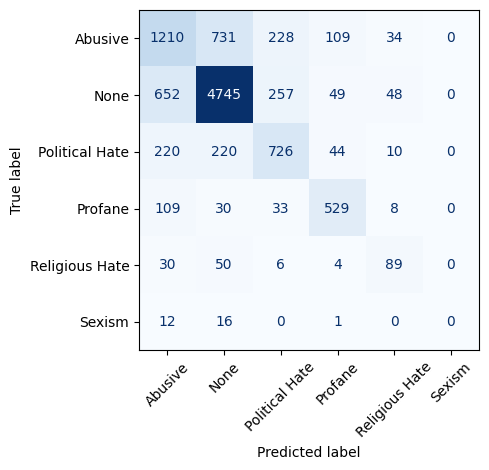

<Figure size 700x600 with 0 Axes>

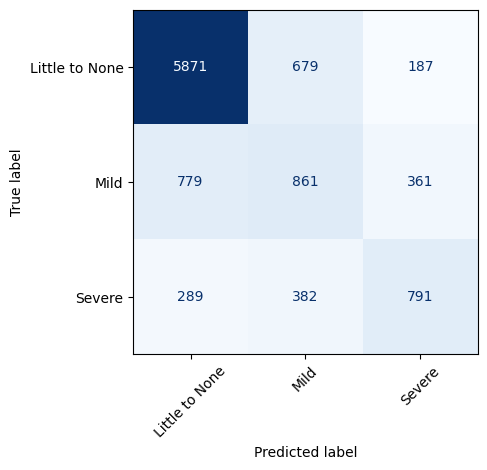

<Figure size 700x600 with 0 Axes>

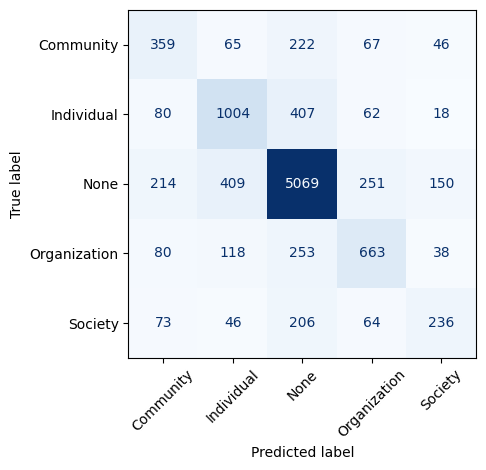

In [9]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load uploaded files
truth_df = pd.read_csv("gold.tsv", sep="\t")
pred_df = pd.read_csv("pred.tsv", sep="\t")

# Merge
merged_df = pd.merge(truth_df, pred_df, on="id", suffixes=("_true", "_pred"))

# Generate confusion matrices for each target column
for col in ["hate_type", "hate_severity", "to_whom"]:
    true_col = f"{col}_true"
    pred_col = f"{col}_pred"

    # Convert all to strings to avoid NaN/float issues
    y_true = merged_df[true_col].fillna("None").astype(str)
    y_pred = merged_df[pred_col].fillna("None").astype(str)

    labels = sorted(list(set(y_true.unique()) | set(y_pred.unique())))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Display confusion matrix
    plt.figure(figsize=(7, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues", colorbar=False)
    plt.tight_layout()
    plt.show()


In [7]:
from sklearn.metrics import f1_score
import pandas as pd

# Load data
truth_df = pd.read_csv("gold.tsv", sep="\t")
pred_df = pd.read_csv("pred.tsv", sep="\t")

# Merge gold + predictions
merged_df = pd.merge(truth_df, pred_df, on="id", suffixes=("_true", "_pred"))

# Compute micro-F1 for each target column
for col in ["hate_type", "hate_severity", "to_whom"]:
    y_true = merged_df[f"{col}_true"].fillna("None").astype(str)
    y_pred = merged_df[f"{col}_pred"].fillna("None").astype(str)

    f1_micro = f1_score(y_true, y_pred, average="micro")
    print(f"{col.replace('_', ' ').title()} — Micro F1: {f1_micro:.4f}")


Hate Type — Micro F1: 0.7156
Hate Severity — Micro F1: 0.7375
To Whom — Micro F1: 0.7187


In [8]:
from sklearn.metrics import f1_score
import pandas as pd

# Load data
truth_df = pd.read_csv("gold.tsv", sep="\t")
pred_df = pd.read_csv("pred.tsv", sep="\t")

# Merge gold + predictions
merged_df = pd.merge(truth_df, pred_df, on="id", suffixes=("_true", "_pred"))

# Compute micro-F1 for each target column
f1_scores = {}
for col in ["hate_type", "hate_severity", "to_whom"]:
    y_true = merged_df[f"{col}_true"].fillna("None").astype(str)
    y_pred = merged_df[f"{col}_pred"].fillna("None").astype(str)

    f1_micro = f1_score(y_true, y_pred, average="micro")
    f1_scores[col] = f1_micro
    print(f"{col.replace('_', ' ').title()} — Micro F1: {f1_micro:.4f}")

# Compute total average (across the three tasks)
total_avg_f1 = sum(f1_scores.values()) / len(f1_scores)
print(f"\nOverall Average Micro F1 (across all tasks): {total_avg_f1:.4f}")


Hate Type — Micro F1: 0.7156
Hate Severity — Micro F1: 0.7375
To Whom — Micro F1: 0.7187

Overall Average Micro F1 (across all tasks): 0.7240
